In [1]:
import numpy as np
import cPickle as pkl

In [2]:
f = open("data/mnist.pkl", "rb")
data = pkl.load(f)
f.close()

In [3]:
trainX = data[0][0]
trainY = data[0][1]

valX = data[1][0]
valY = data[1][1]

testX = data[2][0]
testY = data[2][1]

meanX = np.mean(trainX, axis=0)
stdX = np.std(trainX, axis=0)

trainX = (trainX - meanX)
testX = (testX - meanX)
valX = (valX - meanX)

In [4]:
import numpy as np
import math
from random import randrange

class NeuralNet(object):
    
    def __init__(self, input_size, hidden_size, output_size):
        
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size) * math.sqrt(2.0 / input_size)
        self.params['b1'] = np.zeros((1,hidden_size))
        self.params['W2'] = np.random.randn(hidden_size, output_size) * math.sqrt(2.0 / hidden_size)
        self.params['b2'] = np.zeros((1,output_size))
        
        pass
    
    def __oneHot(self, vector):
        encoded_vector = np.zeros((vector.size, vector.max()+1), dtype=vector.dtype)
        encoded_vector[np.arange(vector.size), vector] = 1
        return encoded_vector
    
    def __softmax(self, x):
        z = np.exp(x)
        return z / np.sum(z,axis=1,keepdims=True)
    
    def loss(self, X, rawY, reg=0.0, dropout=1.0):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
        y = self.__oneHot(rawY)
        N,D = X.shape
        H,K = W2.shape
        
        z1 = np.dot(X, W1) + b1
        
        dz1_db1 = 1.0
        dz1_dW1 = X.T
        dz1_dX = W1.T
        
        
        z2 = np.maximum(0, z1)
        
        dropoutMask = (np.random.rand(*z2.shape) < dropout) / dropout
        z2 *= dropoutMask
        
        dz2_dz1 = (z2 > 0) * np.ones(z2.shape)
        
        
        z3 = np.dot(z2, W2) + b2
        dz3_dz2 = W2.T
        dz3_dW2 = z2.T
        dz3_db2 = 1.0
        
        probs = self.__softmax(z3)
        
        data_loss = -1.0 * np.sum(y * np.log(probs)) / N
        reg_loss = (reg / 2) * (np.sum(W1**2) + np.sum(W2**2)) / N
        loss = data_loss + reg_loss
        
        grad = probs - y
        
        db2 = np.sum(grad * dz3_db2, axis=0, keepdims=True)
        dW2 = np.dot(dz3_dW2, grad) + (reg * W2)
        
        dz2 = np.dot(grad, dz3_dz2)
        dz2 *= dropoutMask
        
        dz1 = dz2_dz1 * dz2
        db1 = np.sum(dz1_db1 * dz1, axis=0, keepdims=True)
        dW1 = np.dot(dz1_dW1, dz1) + (reg * W1)
        
        return loss, dW1, dW2, db1, db2
    
    def train(self, X, Y, learning_rate, iters=100, mode="nesterov", reg=0.0, dropout=1.0, eps=1e-8, beta1=0.9, beta2=0.99, mu=0.9, valX=None, valY=None):
        batch_size = 512
        batchesX = np.array_split(X, X.shape[0]/batch_size)
        batchesY = np.array_split(Y, Y.shape[0]/batch_size)
        
        v1 = 0
        v1Prev = 0
        v2 = 0
        v2Prev = 0
        
        loss_trend = []
        acc_trend = []
        
        for t in xrange(iters):
            for b in xrange(len(batchesX)):
                
                loss, dW1, dW2, db1, db2 = self.loss(batchesX[b], batchesY[b], reg)
                if mode == "nesterov":
                    v1Prev = v1
                    v1 = mu * v1 - learning_rate * dW1
                    self.params['W1'] += -mu * v1Prev + (1 + mu) * v1
                    self.params['b1'] += -learning_rate * db1

                    v2Prev = v2
                    v2 = mu * v2 - learning_rate * dW2
                    self.params['W2'] += -mu * v2Prev + (1 + mu) * v2
                    self.params['b2'] += -learning_rate * db2
            
            loss_trend.append(loss)
            if valX is not None:
                acc = self.predict(valX, valY)
                acc_trend.append(acc)
                print "Iteration %d; Loss = %f; Validation Acc = %f" % (t, loss, acc)
            else:
                print "Iteration %d; Loss = %f" % (t, loss)
        return loss_trend, acc_trend
    
    def predict(self, X, rawY):
        
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
        y = self.__oneHot(rawY)
        N,D = X.shape
        H,K = W2.shape
        
        z1 = np.dot(X, W1) + b1
        z2 = np.maximum(0, z1)
        z3 = np.dot(z2, W2) + b2
        probs = self.__softmax(z3)
        predY = np.argmax(probs, axis=1)
        acc = np.mean(np.equal(rawY, predY))
        return acc
    
    def gradCheckRelative(self, X, rawY, num_checks):
        h = 1e-4
        l, analytic_grad_one, analytic_grad_two = self.loss(X, rawY)
        
        for i in xrange(num_checks):
            ix2 = tuple([randrange(m) for m in self.params['W2'].shape])
            
            self.params['W2'][ix2] += h
            fxph, a1, a2 = self.loss(X, rawY)
            
            self.params['W2'][ix2] -= 2*h
            fxmh, a1, a2 = self.loss(X, rawY)
            
            self.params['W2'][ix2] += h
            
            grad_numerical = (fxph - fxmh) / (2*h)
            grad_analytic = analytic_grad_two[ix2]
            
            rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
            print 'numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error)
        

Learning Rate:  4.73933601186e-05
Regularization:  7.42835934881e-06
Dropout:  0.621400693697
Iteration 0; Loss = 0.460948; Validation Acc = 0.918400
Iteration 1; Loss = 0.363391; Validation Acc = 0.936300
Iteration 2; Loss = 0.309479; Validation Acc = 0.946500
Iteration 3; Loss = 0.272142; Validation Acc = 0.954100
Iteration 4; Loss = 0.243854; Validation Acc = 0.959000
Iteration 5; Loss = 0.221477; Validation Acc = 0.962700
Iteration 6; Loss = 0.203160; Validation Acc = 0.964900
Iteration 7; Loss = 0.187629; Validation Acc = 0.966600
Iteration 8; Loss = 0.174375; Validation Acc = 0.967900
Iteration 9; Loss = 0.162713; Validation Acc = 0.969200


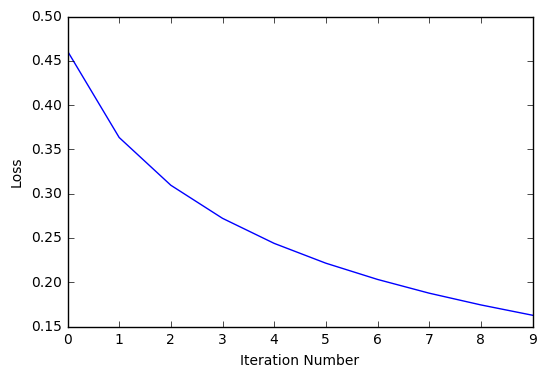

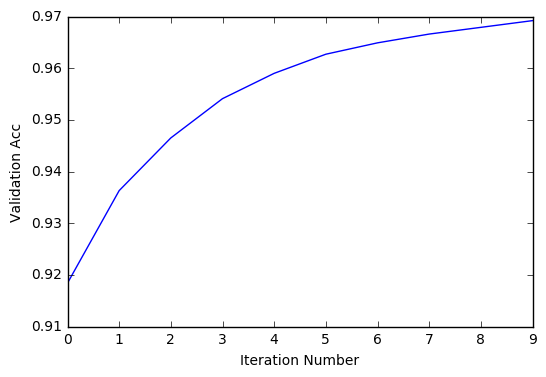

Learning Rate:  2.69181906513e-07
Regularization:  4.79349543013e-06
Dropout:  0.80560132634
Iteration 0; Loss = 2.224727; Validation Acc = 0.248000
Iteration 1; Loss = 2.073681; Validation Acc = 0.409200
Iteration 2; Loss = 1.941777; Validation Acc = 0.530400
Iteration 3; Loss = 1.826330; Validation Acc = 0.610900
Iteration 4; Loss = 1.725060; Validation Acc = 0.661700
Iteration 5; Loss = 1.635874; Validation Acc = 0.695800
Iteration 6; Loss = 1.556988; Validation Acc = 0.723000
Iteration 7; Loss = 1.486854; Validation Acc = 0.744100
Iteration 8; Loss = 1.424209; Validation Acc = 0.760400
Iteration 9; Loss = 1.367959; Validation Acc = 0.776200


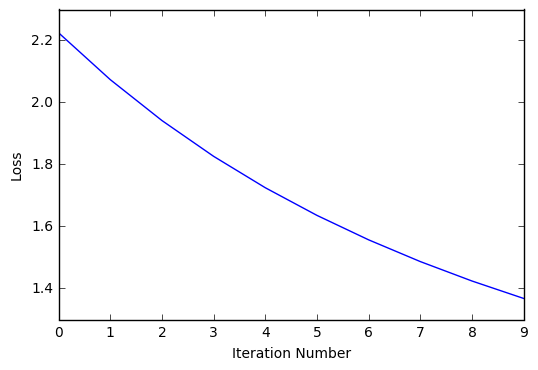

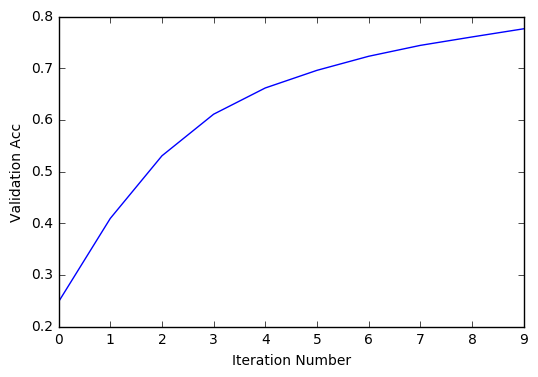

Learning Rate:  2.95934996934e-05
Regularization:  1.70056912583e-08
Dropout:  0.778003415096


KeyboardInterrupt: 

In [119]:
import numpy as np
import matplotlib.pyplot as plt

for i in range(10):
    learning_rate = 10**np.random.uniform(-7, -4)
    reg = 10**np.random.uniform(-8, -4)
    dropout = np.random.uniform(0.5, 0.9)
    
    print "==========================================================="
    print "Learning Rate: ",learning_rate
    print "Regularization: ", reg
    print "Dropout: ", dropout
    print "==========================================================="
    
    nn = NeuralNet(784, 1024, 10)
    loss_trend, acc_trend = nn.train(trainX, trainY, 
                                     learning_rate=learning_rate, 
                                     reg=reg,
                                     dropout=dropout,
                                     mode="nesterov",
                                     iters=10,
                                     valX=valX,
                                     valY=valY
                                    )
    
    
    plt.plot(loss_trend)
    plt.xlabel('Iteration Number')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(acc_trend)
    plt.xlabel('Iteration Number')
    plt.ylabel('Validation Acc')
    plt.show()
    print "==========================================================="

In [14]:
nn = NeuralNet(784, 1024, 10)
l,a = nn.train(trainX, trainY, 
               learning_rate=4.8e-5, 
               reg=7.43e-06,
               dropout=0.7,
               iters=80, mode="nesterov", valX=valX, valY=valY)

Iteration 0; Loss = 0.454186; Validation Acc = 0.918300
Iteration 1; Loss = 0.358210; Validation Acc = 0.938100
Iteration 2; Loss = 0.304693; Validation Acc = 0.947000
Iteration 3; Loss = 0.267989; Validation Acc = 0.953400
Iteration 4; Loss = 0.240631; Validation Acc = 0.958900
Iteration 5; Loss = 0.219210; Validation Acc = 0.962900
Iteration 6; Loss = 0.201784; Validation Acc = 0.964600
Iteration 7; Loss = 0.187052; Validation Acc = 0.966700
Iteration 8; Loss = 0.174373; Validation Acc = 0.968200
Iteration 9; Loss = 0.163292; Validation Acc = 0.969700
Iteration 10; Loss = 0.153443; Validation Acc = 0.971800
Iteration 11; Loss = 0.144664; Validation Acc = 0.972400
Iteration 12; Loss = 0.136660; Validation Acc = 0.972700
Iteration 13; Loss = 0.129311; Validation Acc = 0.973400
Iteration 14; Loss = 0.122516; Validation Acc = 0.973900
Iteration 15; Loss = 0.116138; Validation Acc = 0.974300
Iteration 16; Loss = 0.110236; Validation Acc = 0.974800
Iteration 17; Loss = 0.104758; Validation

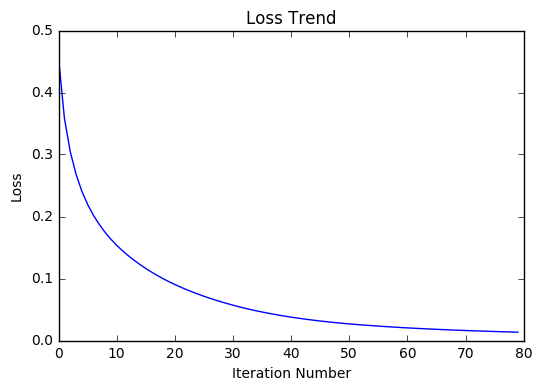

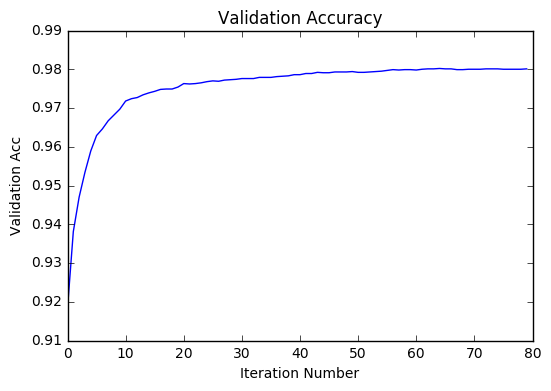

In [15]:
import matplotlib.pyplot as plt

plt.title("Loss Trend")
plt.plot(l)
plt.xlabel('Iteration Number')
plt.ylabel('Loss')
plt.show()

plt.title("Validation Accuracy")
plt.plot(a)
plt.xlabel('Iteration Number')
plt.ylabel('Validation Acc')
plt.show()

In [16]:
nn.predict(testX, testY)

0.97989999999999999

In [17]:
f = open("model.pkl", "wb")
pkl.dump(nn.params, f)
f.close()

In [18]:
g = open("model.pkl", "rb")
ps = pkl.load(g)
g.close()

In [19]:
ps

{'W1': array([[ 0.02358799,  0.04952753, -0.00499204, ...,  0.03900779,
          0.01176214, -0.0344297 ],
        [-0.01744658,  0.03420504, -0.01697909, ..., -0.03331446,
         -0.10485627, -0.0381652 ],
        [ 0.00598393,  0.03781395,  0.02977438, ..., -0.01032498,
         -0.00771547, -0.01900692],
        ..., 
        [ 0.00771383, -0.00912284, -0.01671338, ...,  0.02106959,
          0.01899807,  0.03163303],
        [-0.07725453,  0.04271933,  0.05919148, ..., -0.02272257,
         -0.05561921, -0.00728846],
        [ 0.07501819,  0.03462626,  0.00998274, ...,  0.03338658,
          0.01603813,  0.04922299]]),
 'W2': array([[ 0.0623216 , -0.09432601, -0.03387387, ..., -0.05600372,
         -0.05047042,  0.0110547 ],
        [-0.12640681, -0.20242342, -0.05942996, ..., -0.32761666,
          0.32944506,  0.31916671],
        [-0.0353363 ,  0.06848771, -0.12292457, ...,  0.0356695 ,
          0.23049551, -0.11300927],
        ..., 
        [-0.12095684,  0.03388013,  0.03

In [127]:
nn.params

{'W1': array([[-0.00620406,  0.04648852, -0.00086875, ..., -0.06827899,
         -0.10209567,  0.01097941],
        [-0.00350254, -0.14189766, -0.03269973, ..., -0.05593574,
          0.01471785, -0.04034381],
        [-0.05370273, -0.0432149 ,  0.08023653, ..., -0.07254699,
         -0.00926074,  0.02510681],
        ..., 
        [-0.13254043, -0.07850912, -0.02064936, ...,  0.00618961,
         -0.00122092,  0.06571711],
        [-0.00802712, -0.00028038, -0.0914077 , ..., -0.09721427,
         -0.06564448,  0.04312704],
        [ 0.04627128,  0.01408062,  0.01610101, ..., -0.06228868,
         -0.08792639, -0.01145644]]),
 'W2': array([[-0.01471874,  0.19545259, -0.03967633, ..., -0.04400255,
         -0.07638944, -0.07592068],
        [-0.04838743,  0.08085669, -0.0968442 , ..., -0.02134387,
         -0.09648887,  0.0251197 ],
        [-0.07876032,  0.03408682, -0.05033222, ...,  0.067783  ,
         -0.06097748, -0.01167352],
        ..., 
        [-0.04084174, -0.00621925, -0.04